In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1- Definition of a Lasso regression function

Three different versions are implemented
- Gradient descent Lasso
- ADMM Lasso
- ADMM Distributed Lasso

In [2]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")

    def gradient_descent(self):
        for i in range(1, self.max_iterations + 1):
            Y_predict = self.predict(self.X).flatten()

            soft_term = self.soft_threshold(self.W, self.l1_penalty)
            dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
            
            new_W = self.W - self.step_size * dW
            
            if np.linalg.norm(new_W - self.W) < self.tolerance:
                break 

            self.J.append((np.linalg.norm(new_W - self.W),))
            self.W = new_W
            self.iterations = i

    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)
            

            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''
            if r_norm < tol_prim and s_norm < tol_dual :
                break 

        self.W = self.W.reshape(1, -1)

    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        #print(f"Total rows used: {total_rows_used}")
        #print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)
            
            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)

## 1.2- Definition of plot functions

In [3]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='brown', label='Predicted vs. Measured')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4, label='Ideal')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot(J, title):
    plt.plot(J, color='brown', label='Total Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot_admm(J, title):
    r_loss = [row[0] for row in J]  
    s_loss = [row[1] for row in J]  

    plt.plot(r_loss, label='Primary Residual', color='purple')
    plt.plot(s_loss, label='Dual Residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [22]:
def loss_plot_admm_val(ax, loss_data, title):
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 0], label='Primal Residual', color = 'purple')
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 1], label='Dual Residual', color = 'green')
    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

def loss_plot_distributed_admm_val(ax, lasso_model, title):
    r_loss = [row[0] for row in lasso_model.J]
    s_loss = [row[1] for row in lasso_model.J]

    ax.plot(np.arange(1, len(lasso_model.J) + 1), r_loss, label='Primary Residual', color='purple')
    ax.plot(np.arange(1, len(lasso_model.J) + 1), s_loss, label='Dual Residual', color='green')

    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

# 2- Test on first synthetically generated dataset

## 2.1- Dataset generation

A simple dataset is generated to test the functioning of the 3 versions of Lasso

In [5]:
n_features = 3

X_num = np.random.rand(300, n_features)
X_cat = np.random.randint(0, 2, (300, 1))
X_cat_one_hot = pd.get_dummies(X_cat.flatten(), prefix='cat', drop_first=True).values
X = np.concatenate((X_num, X_cat_one_hot), axis=1)

y = 2 * X[:, 0] + X[:, 1] + 0.1 * np.random.randn(300)

In [6]:
print(X.shape)

X_dataframe = pd.DataFrame(X, columns=["X1", "X2", "X3", "cat_0"])
print(X_dataframe.head())

(300, 4)
         X1        X2        X3  cat_0
0  0.072440  0.132831  0.540168    0.0
1  0.187998  0.231315  0.429808    1.0
2  0.003977  0.629579  0.072018    1.0
3  0.233500  0.643723  0.161896    0.0
4  0.052419  0.997895  0.401638    0.0


In [7]:
y_dataframe = pd.DataFrame(y, columns=["Y"])
print(y_dataframe.head())

          Y
0  0.307905
1  0.750404
2  0.729935
3  1.035118
4  1.120428


Visualize distribution of data

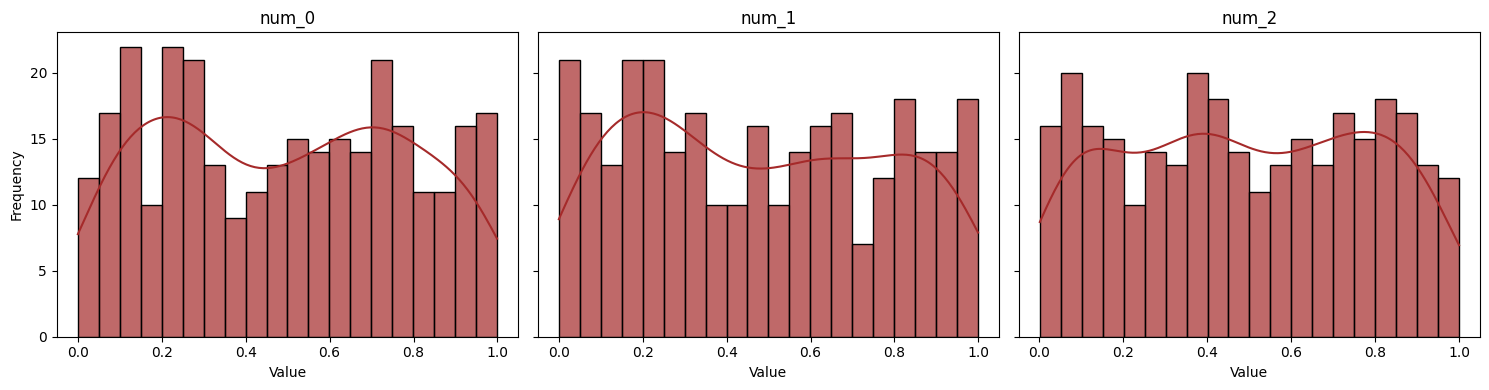

In [8]:
fig, axes = plt.subplots(1, n_features, figsize=(15, 4), sharey=True)

for i in range(n_features):
    sns.histplot(X[:, i], bins=20, kde=True, ax=axes[i], color='brown', alpha=0.7)
    axes[i].set_title(f'num_{i}')
    axes[i].set_xlabel('Value')

axes[0].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

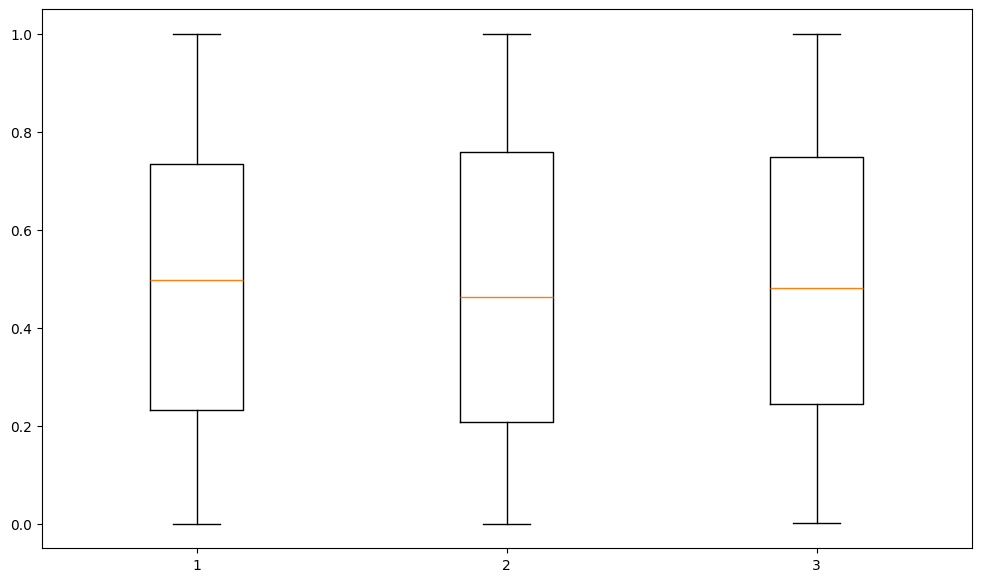

In [9]:
plt.figure(figsize=(12, 7))
plt.boxplot(X_num)
plt.show()

Visualize the distribution of target variable

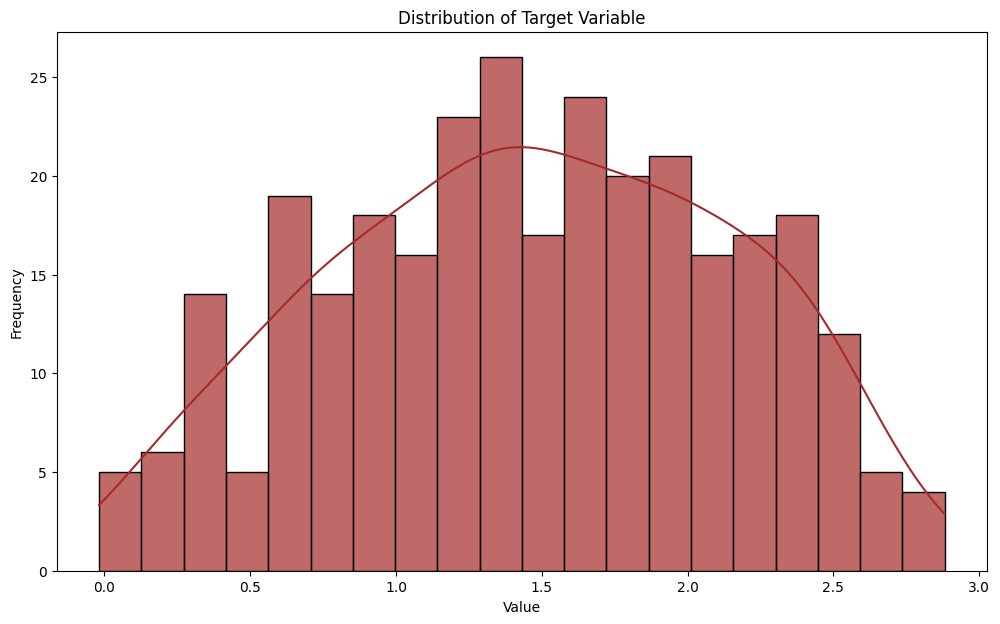

In [10]:
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Division of the dataset into train set and test set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data normalisation

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 2.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 2.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [15]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train, y_train, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test)

    r2 = r2_score(y_test, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")

GD time with step_size 0.001: 0.027033567428588867
GD iterations with step_size 0.001: 551
R^2 with step_size 0.001: 0.031690616745580935
GD time with step_size 0.01: 0.026000261306762695
GD iterations with step_size 0.01: 537
R^2 with step_size 0.01: 0.9114457498280333
GD time with step_size 0.1: 0.007006168365478516
GD iterations with step_size 0.1: 173
R^2 with step_size 0.1: 0.9753513814263839
GD time with step_size 0.5: 0.0019981861114501953
GD iterations with step_size 0.5: 51
R^2 with step_size 0.5: 0.9776890346722472


Validation of l1_penalty parameter

In [16]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train, y_train, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test)

    r2 = r2_score(y_test, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.00397944450378418
GD iterations with l1_penalty 0.01: 51
R^2 with l1_penalty 0.01: 0.9776460969145312
GD time with l1_penalty 0.1: 0.0030019283294677734
GD iterations with l1_penalty 0.1: 51
R^2 with l1_penalty 0.1: 0.9776890346722472
GD time with l1_penalty 1: 0.003015756607055664
GD iterations with l1_penalty 1: 51
R^2 with l1_penalty 1: 0.9782709179737741
GD time with l1_penalty 10: 0.0030143260955810547
GD iterations with l1_penalty 10: 52
R^2 with l1_penalty 10: 0.9791625005438648


### 2.2.2- Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.011004209518432617
ADMM iterations with step_size 0.001: 101
R^2 with step_size 0.001: 0.9794613703413095
ADMM time with step_size 0.01: 0.0009927749633789062
ADMM iterations with step_size 0.01: 11
R^2 with step_size 0.01: 0.9794680136700475
ADMM time with step_size 0.1: 0.0009999275207519531
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.9794633964134805
ADMM time with step_size 0.5: 0.0010149478912353516
ADMM iterations with step_size 0.5: 3
R^2 with step_size 0.5: 0.9794806216397224


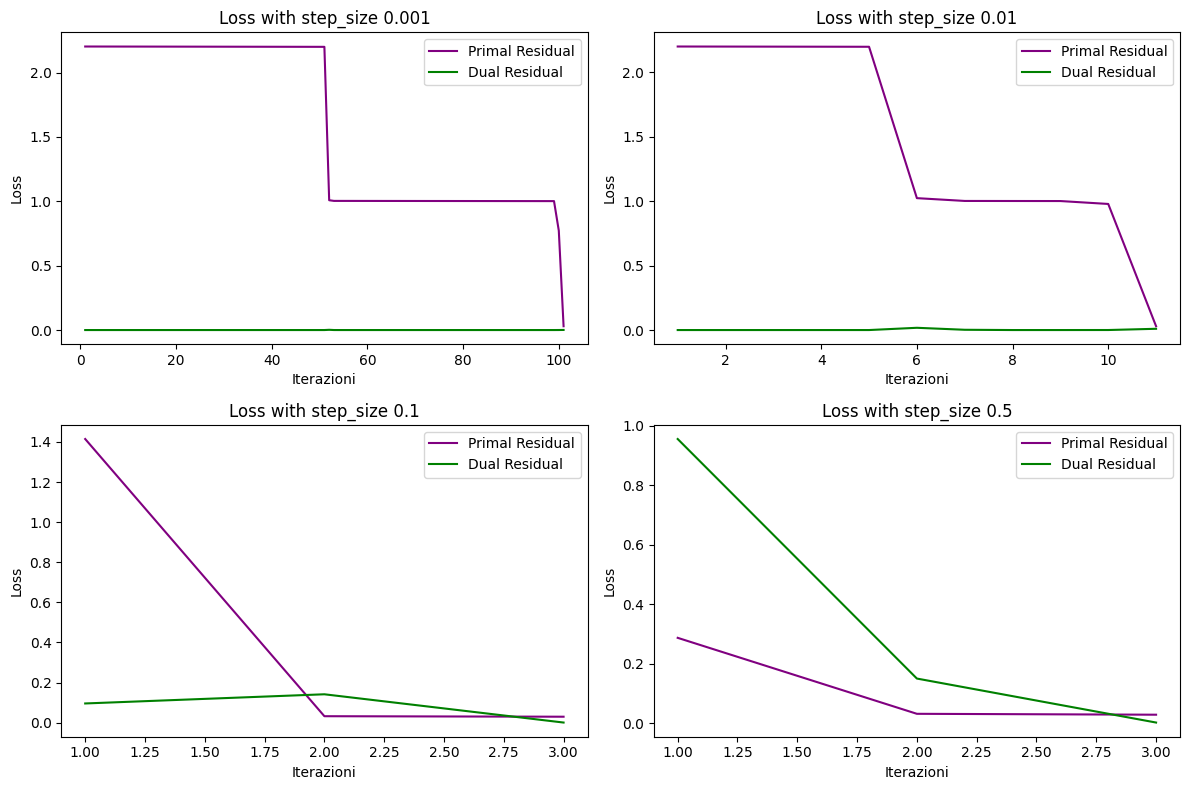

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train, y_train, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test)

    r2 = 1 - np.mean((y_test - y_pred_admm) ** 2) / np.var(y_test)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0010101795196533203
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.9795469177973708
ADMM time with l1_penalty 0.1: 0.0
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.9794633964134805
ADMM time with l1_penalty 1: 0.0019960403442382812
ADMM iterations with l1_penalty 1: 11
R^2 with l1_penalty 1: 0.9783630414405295
ADMM time with l1_penalty 10: 0.014034509658813477
ADMM iterations with l1_penalty 10: 159
R^2 with l1_penalty 10: 0.946808068033342


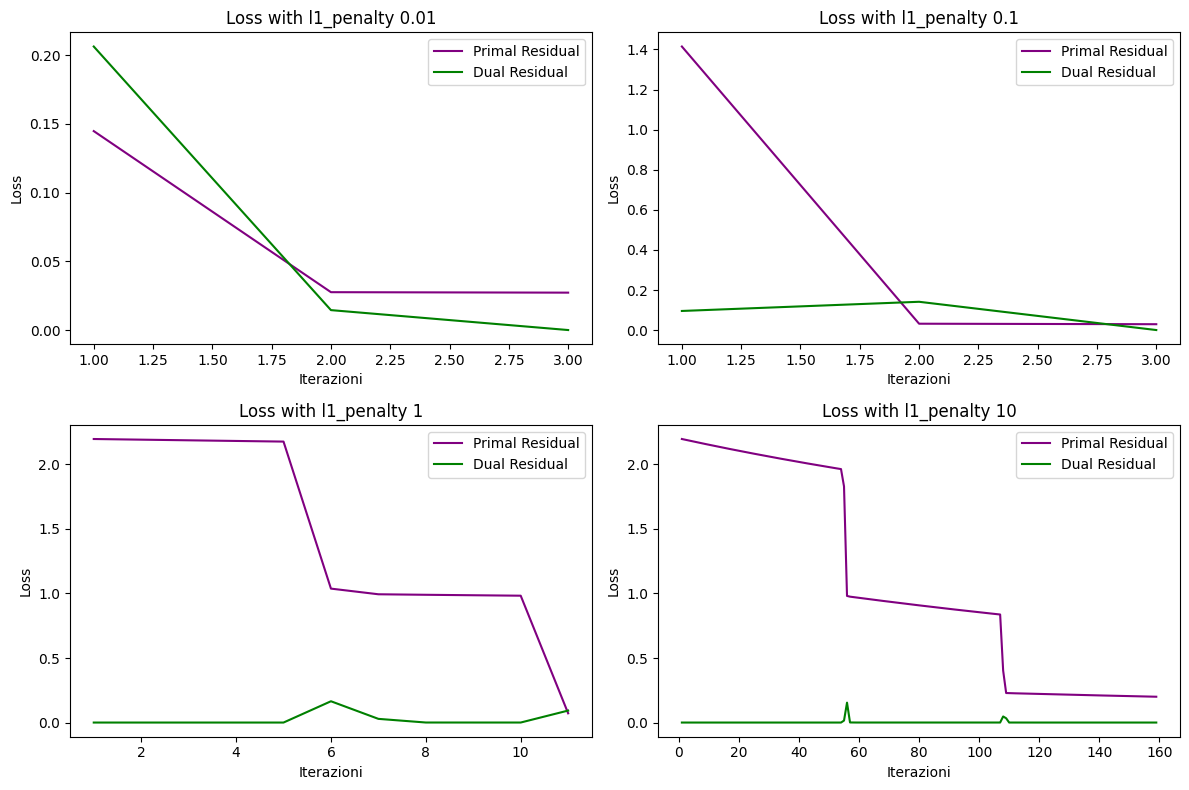

In [42]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train, y_train, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()    

### 2.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.01200246810913086
Distributed ADMM iterations with step_size 0.001: 34
R^2 with step_size 0.001: 0.9796247596706733
Distributed ADMM time with step_size 0.01: 0.0029952526092529297
Distributed ADMM iterations with step_size 0.01: 5
R^2 with step_size 0.01: 0.979627784126297
Distributed ADMM time with step_size 0.1: 0.001008749008178711
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.979626665068751
Distributed ADMM time with step_size 0.5: 0.001033782958984375
Distributed ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.9796404560454668


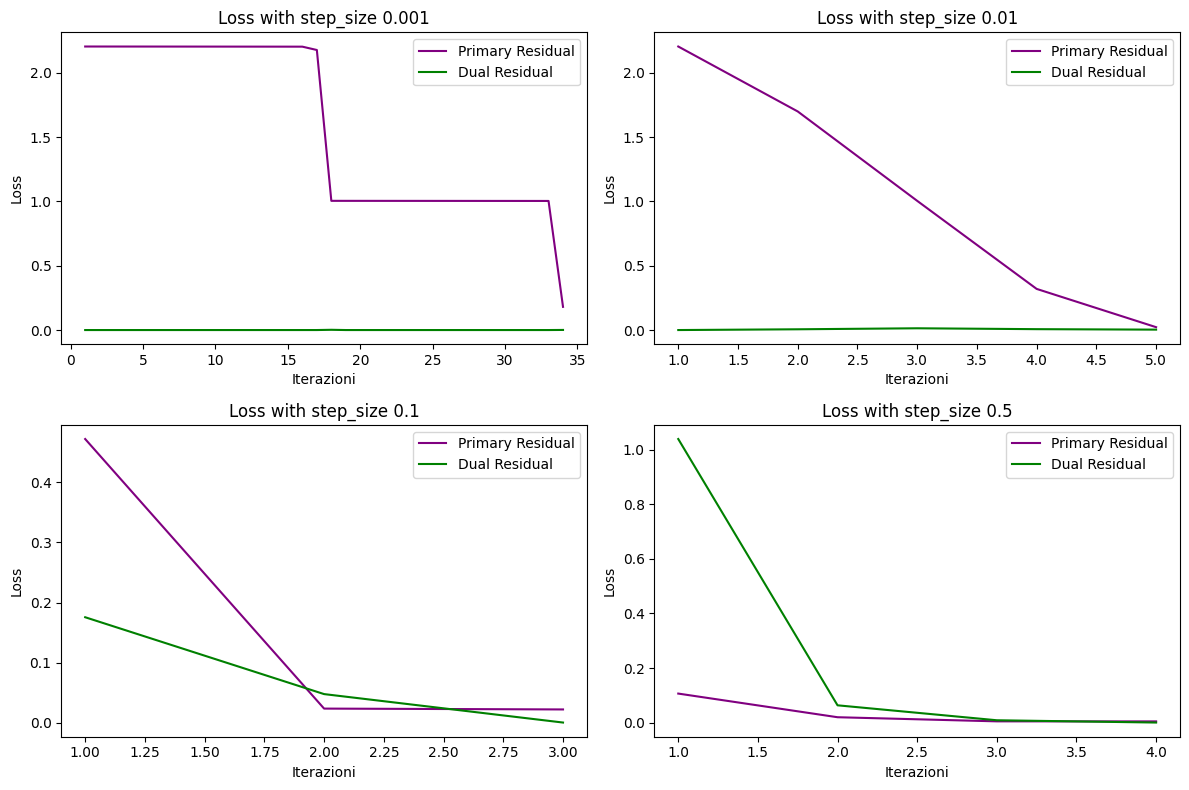

In [32]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()
plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0010190010070800781
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.9796600616855047
Distributed ADMM time with l1_penalty 0.1: 0.0029981136322021484
Distributed ADMM iterations with l1_penalty 0.1: 4
R^2 with l1_penalty 0.1: 0.9796404560454668
Distributed ADMM time with l1_penalty 1: 0.0010001659393310547
Distributed ADMM iterations with l1_penalty 1: 3
R^2 with l1_penalty 1: 0.979203820999221
Distributed ADMM time with l1_penalty 10: 0.0019724369049072266
Distributed ADMM iterations with l1_penalty 10: 8
R^2 with l1_penalty 10: 0.9669027492574247


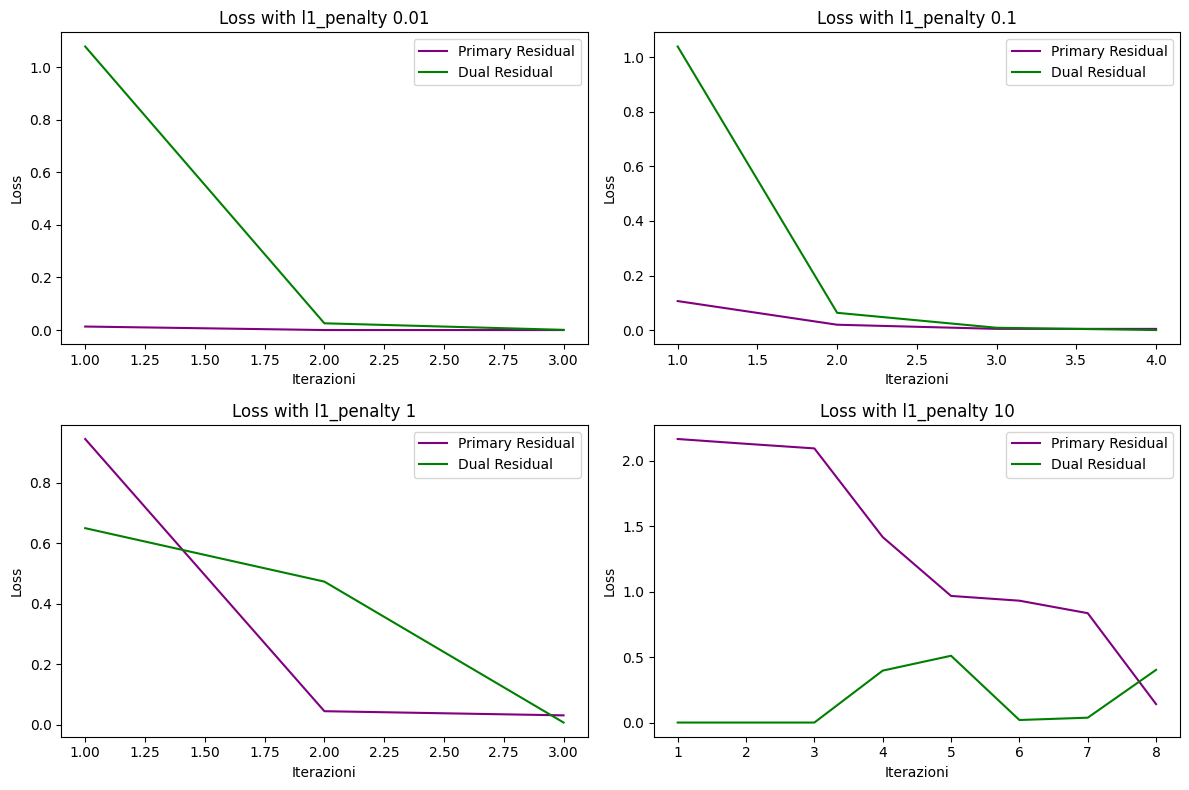

In [34]:
l1_penalties = [0.01, 0.1, 1, 10]
step_size = 0.5
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()
plt.show()

Validation of num_agents parameter

Distributed ADMM time with 3 agents: 0.0009965896606445312
Distributed ADMM iterations with 3 agents: 4
R^2 with 3 agents: 0.9796404560454668
Distributed ADMM time with 5 agents: 0.0010187625885009766
Distributed ADMM iterations with 5 agents: 3
R^2 with 5 agents: 0.9794666451966078
Distributed ADMM time with 10 agents: 0.0020036697387695312
Distributed ADMM iterations with 10 agents: 4
R^2 with 10 agents: 0.9799715855718586
Distributed ADMM time with 20 agents: 0.003043651580810547
Distributed ADMM iterations with 20 agents: 5
R^2 with 20 agents: 0.9805059062397695


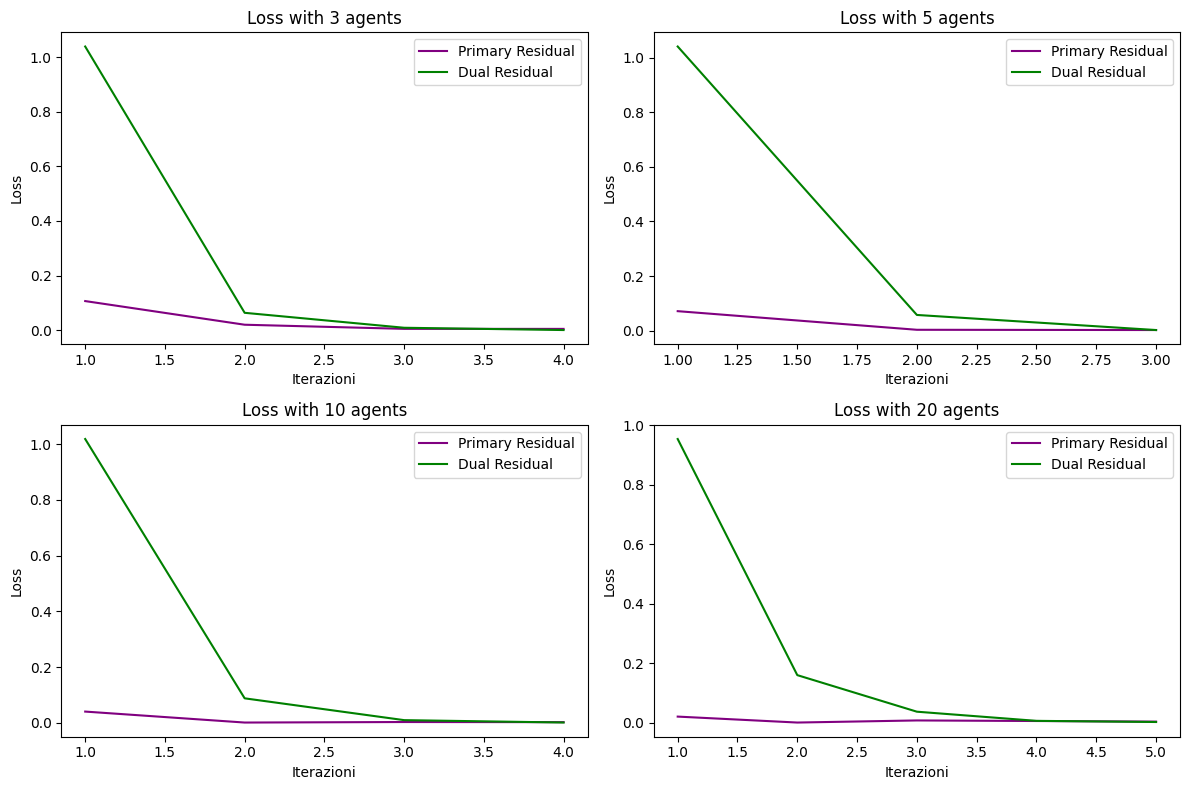

In [43]:
agents = [3, 5, 10, 20]
step_size = 0.5
l1_penalty = 0.1

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()
plt.show()

### 2.2.4 Comparison of Lasso versions

Gradient Descent

GD time: 0.0055315494537353516
GD iterations: 52
R^2: 0.9791625005438648
MSE: 0.010376273825709133
MAE: 0.08291262703167486


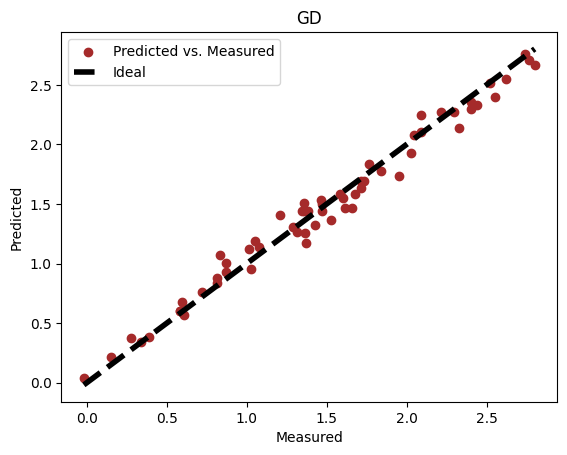

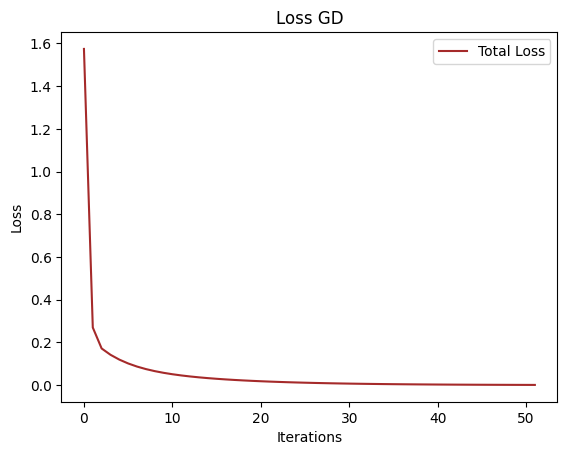

In [44]:
# parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train, y_train, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test)

# metrics
r2_gd = r2_score(y_test, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.0010018348693847656
ADMM iterations: 3
R^2: 0.9795469177973708
MSE: 0.010184848808801382
MAE: 0.0819855984327223


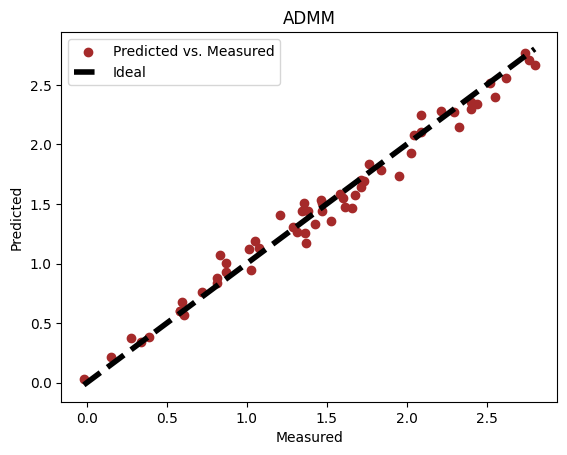

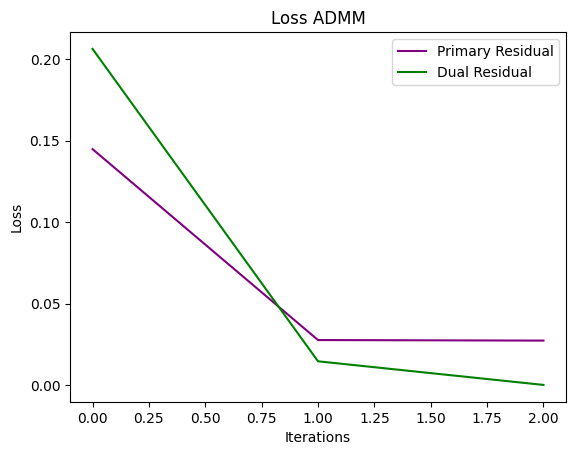

In [45]:
# parameters
step_size = 0.1
l1_penalty = 0.01

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train, y_train, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test)

# metrics
r2_admm = r2_score(y_test, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.0060214996337890625
Distributed ADMM iterations: 5
R^2: 0.9805059062397695
MSE: 0.009707309423859023
MAE: 0.08008066248384477


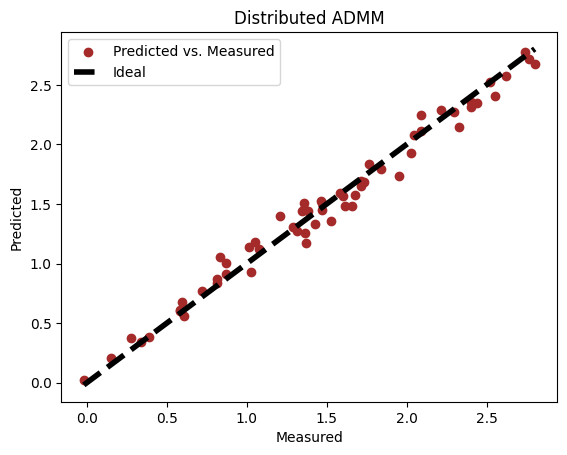

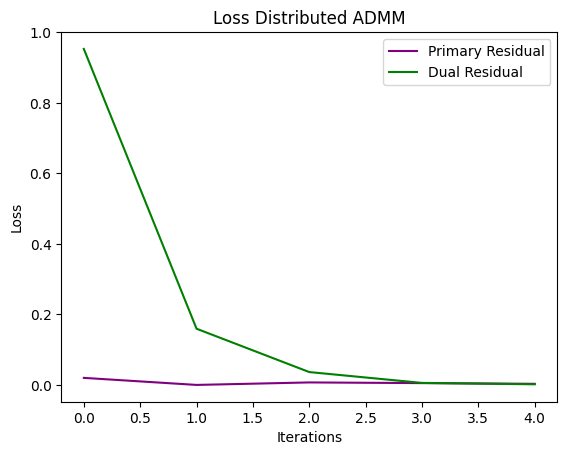

In [46]:
# parameters
step_size = 0.5
l1_penalty = 0.1
agents = 20

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

# metrics
r2_distributed_admm = r2_score(y_test, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")

# 3- Test on second synthetically generated dataset

## 3.1- Dataset generation

A second, more complex dataset is generated

In [53]:
n_num_features = 8
n_cat_features = 2
n_samples = 2000

X_numeric = np.column_stack((
    np.random.normal(loc=7, scale=2, size=(n_samples, 1)),  
    np.random.uniform(low=2, high=12, size=(n_samples, 1)),  
    np.random.exponential(scale=3, size=(n_samples, 1)),  
    np.random.poisson(lam=4, size=(n_samples, 1)),  
    np.random.gamma(shape=3, scale=2, size=(n_samples, 1)),  
    np.random.logistic(loc=-2, scale=1, size=(n_samples, 1)),  
    np.random.chisquare(df=3, size=(n_samples, 1)),  
    np.random.power(a=4, size=(n_samples, 1))                                       
))

X_categorical = np.random.choice([1, 2, 3, 4], size=(n_samples, n_cat_features))

X = np.concatenate((X_numeric, X_categorical), axis=1)

In [54]:
true_weights_numeric = np.random.uniform(-10, 10, n_num_features)

true_weights_categorical = np.random.uniform(-2, 2, n_cat_features)

y = (X_numeric @ true_weights_numeric  + X_categorical @ true_weights_categorical  + 14 + 17 * np.random.randn(n_samples) + np.sin(0.15 * X_numeric[:, 0]) + np.exp(0.2 * X_numeric[:, 1]) + np.cos(0.3 * X_numeric[:, 2]) * X_categorical[:, 0] + np.tanh(0.25 * X_numeric[:, 4]) * X_categorical[:, 1] + 0.25 * np.random.uniform(-10, 71, n_samples))

Visualize distribution of data

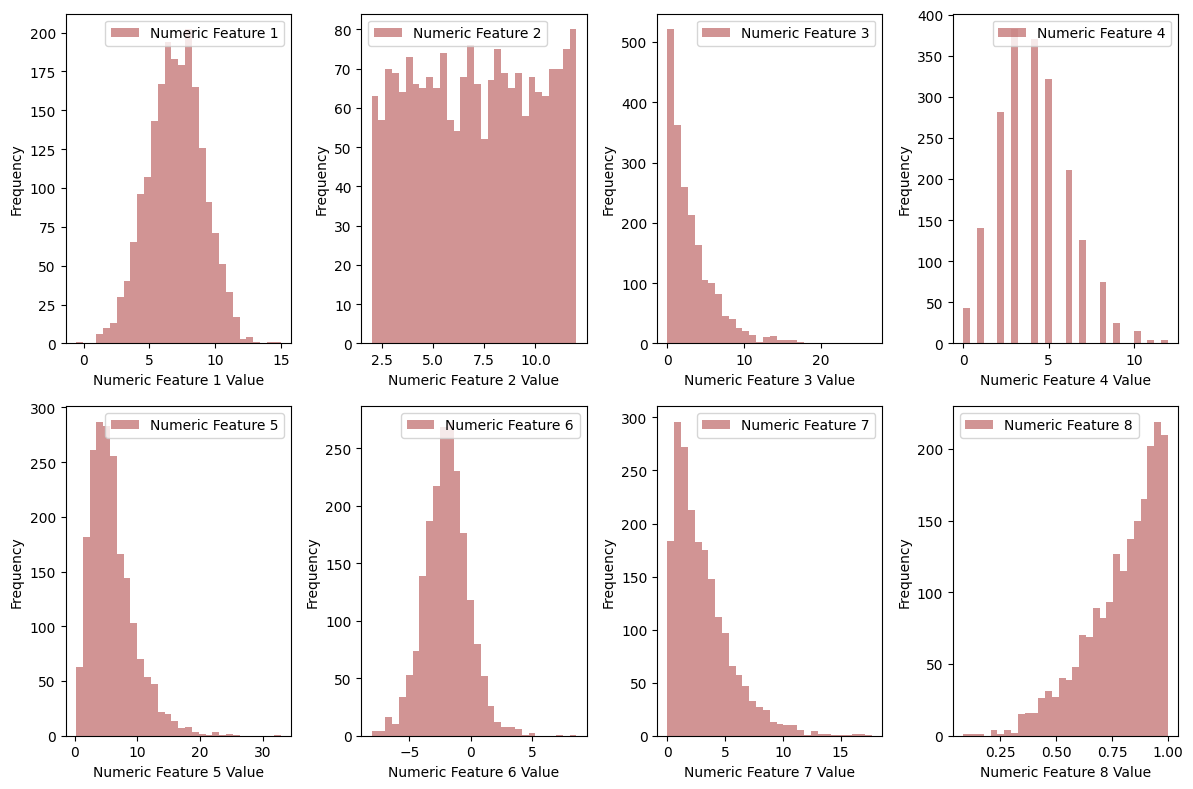

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=n_num_features // 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.hist(X_numeric[:, i], bins=30, alpha=0.5, label=f'Numeric Feature {i + 1}', color='brown')
    ax.legend()
    ax.set_xlabel(f'Numeric Feature {i + 1} Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

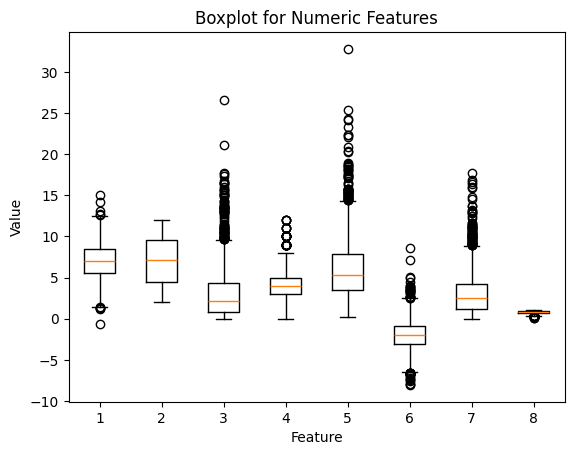

In [56]:
plt.boxplot(X_numeric)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot for Numeric Features')
plt.show()

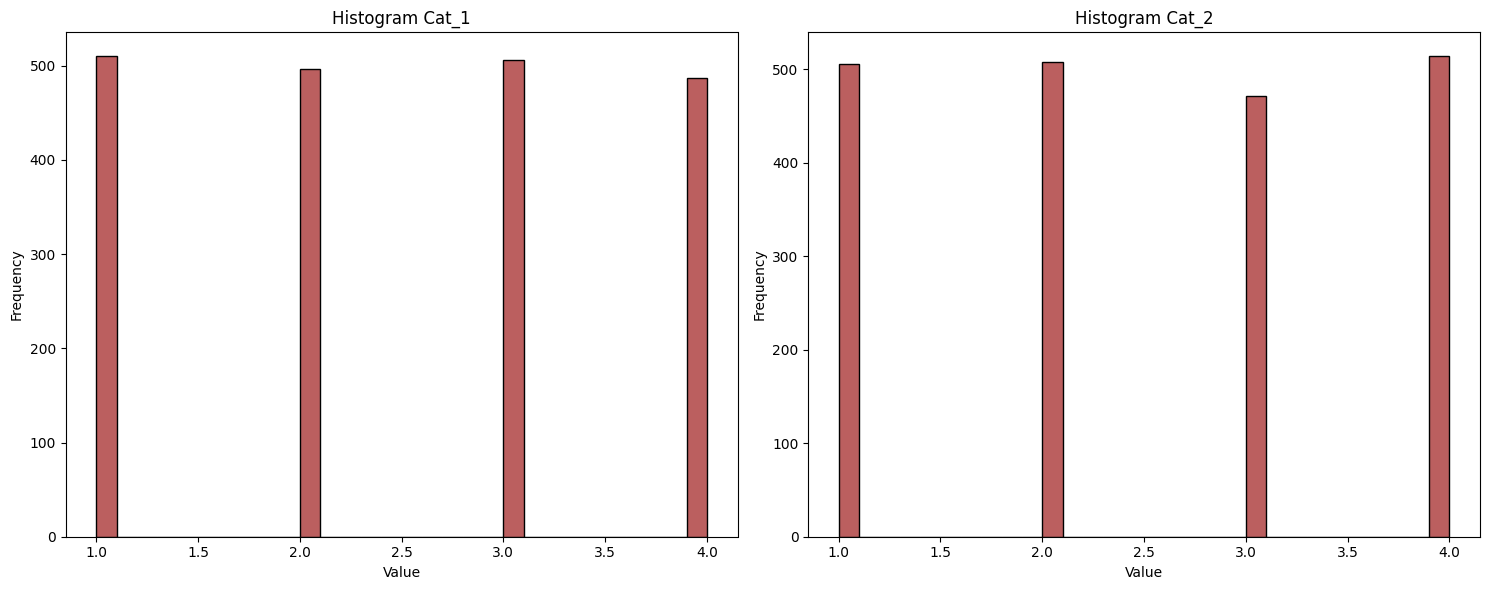

In [57]:
df_cat = pd.DataFrame(X_categorical, columns=[f'Cat_{i + 1}' for i in range(n_cat_features)])

plt.figure(figsize=(15, 6))
for i in range(n_cat_features):
    plt.subplot(1, n_cat_features, i + 1)
    sns.histplot(df_cat[f'Cat_{i + 1}'], bins=30, color='brown', edgecolor='black')
    plt.title(f'Histogram Cat_{i + 1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Visualize distribution of target variable

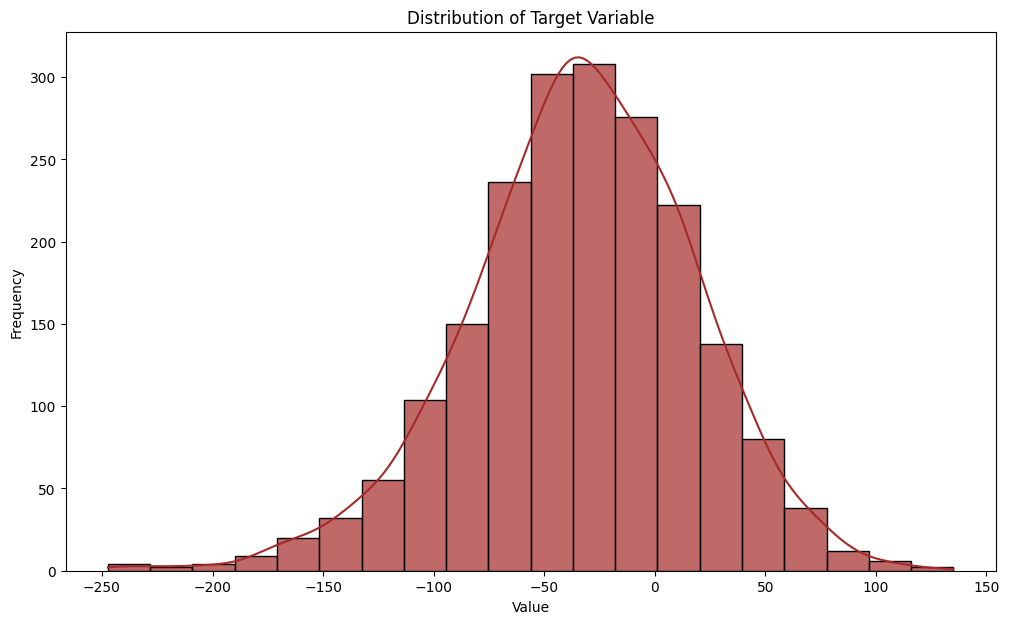

In [58]:
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [59]:
X_one_hot = pd.get_dummies(df_cat, columns=df_cat.columns, drop_first=True).values

X = np.concatenate((X_numeric, X_one_hot), axis=1)

Division of the dataset into train set and test set

In [60]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

Data normalisation

In [61]:
scaler = MinMaxScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [62]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 3.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 3.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [63]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_2, y_train_2, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")


GD time with step_size 0.001: 23.003092050552368
GD iterations with step_size 0.001: 85263
R^2 with step_size 0.001: 0.8720101554646668
GD time with step_size 0.01: 4.707670211791992
GD iterations with step_size 0.01: 17295
R^2 with step_size 0.01: 0.8849385722337773
GD time with step_size 0.1: 0.6756243705749512
GD iterations with step_size 0.1: 2610
R^2 with step_size 0.1: 0.8856363025332394
GD time with step_size 0.5: 0.1979975700378418
GD iterations with step_size 0.5: 643
R^2 with step_size 0.5: 0.8856931923549131


Validation of l1_penalty parameter

In [64]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_2, y_train_2, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.20766401290893555
GD iterations with l1_penalty 0.01: 643
R^2 with l1_penalty 0.01: 0.8856926749308696
GD time with l1_penalty 0.1: 0.1679997444152832
GD iterations with l1_penalty 0.1: 643
R^2 with l1_penalty 0.1: 0.8856931923549131
GD time with l1_penalty 1: 0.2479994297027588
GD iterations with l1_penalty 1: 643
R^2 with l1_penalty 1: 0.8856989114891253
GD time with l1_penalty 10: 0.1660003662109375
GD iterations with l1_penalty 10: 643
R^2 with l1_penalty 10: 0.8857515564252081


### 3.2.2- Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.002001047134399414
ADMM iterations with step_size 0.001: 3
R^2 with step_size 0.001: 0.8869625391766229
ADMM time with step_size 0.01: 0.0030007362365722656
ADMM iterations with step_size 0.01: 5
R^2 with step_size 0.01: 0.8869626744178662
ADMM time with step_size 0.1: 0.0010075569152832031
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.8869626863711526
ADMM time with step_size 0.5: 0.0020127296447753906
ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.8869628091714166


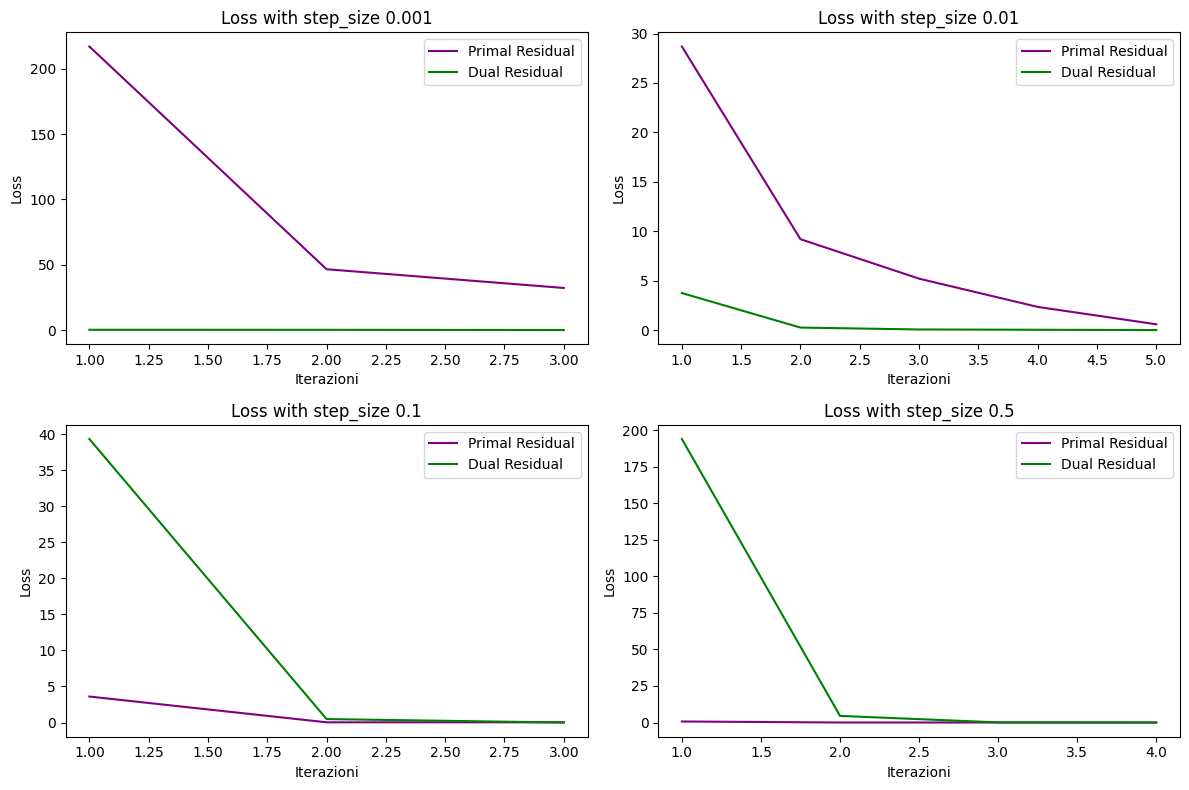

In [65]:
l1_penalty = 0.1
step_sizes = [0.001, 0.01, 0.1, 0.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_2, y_train_2, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_2)

    r2 = 1 - np.mean((y_test_2 - y_pred_admm) ** 2) / np.var(y_test_2)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0019996166229248047
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.8869630531394964
ADMM time with l1_penalty 0.1: 0.0010001659393310547
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.8869626863711526
ADMM time with l1_penalty 1: 0.001999378204345703
ADMM iterations with l1_penalty 1: 5
R^2 with l1_penalty 1: 0.8869589556156825
ADMM time with l1_penalty 10: 0.0010008811950683594
ADMM iterations with l1_penalty 10: 5
R^2 with l1_penalty 10: 0.8869070958556121


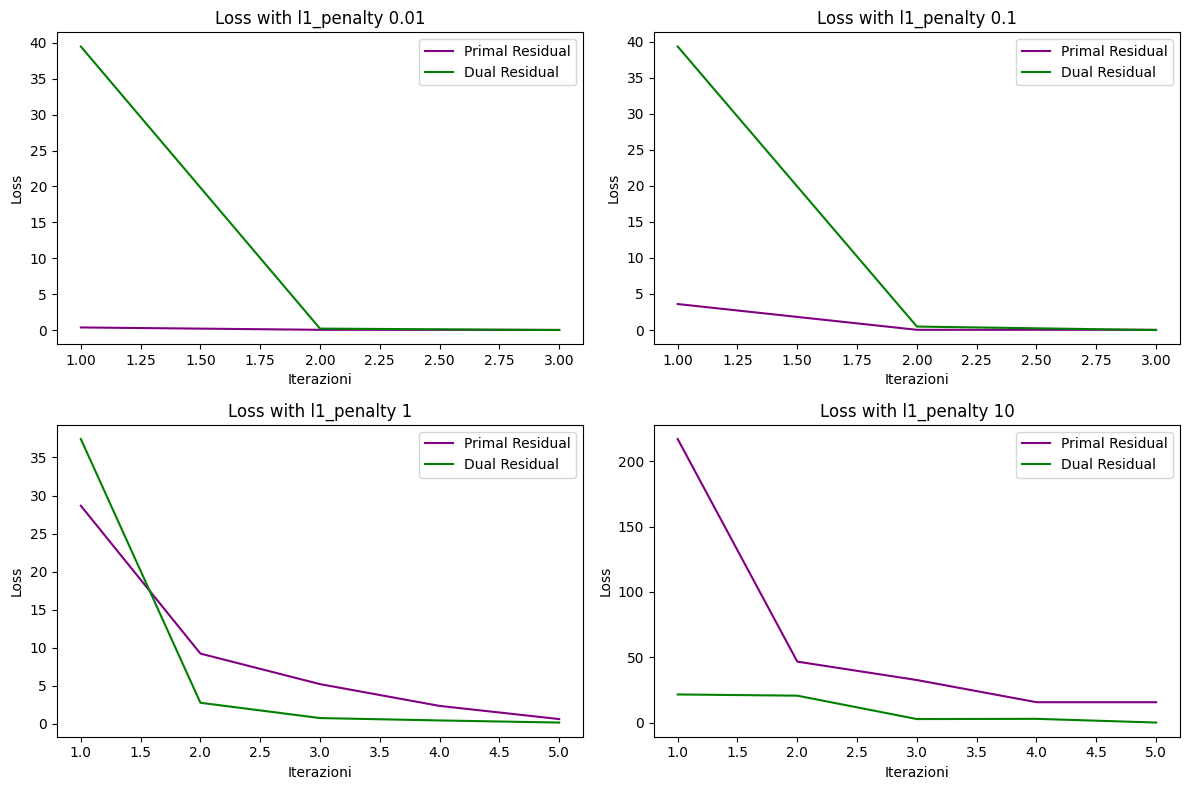

In [66]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_2, y_train_2, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

### 3.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.001001596450805664
Distributed ADMM iterations with step_size 0.001: 3
R^2 with step_size 0.001: 0.8869027809013771
Distributed ADMM time with step_size 0.01: 0.0019998550415039062
Distributed ADMM iterations with step_size 0.01: 3
R^2 with step_size 0.01: 0.8869028668661649
Distributed ADMM time with step_size 0.1: 0.00099945068359375
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.8869038101164992
Distributed ADMM time with step_size 0.5: 0.003002643585205078
Distributed ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.8869088534815273


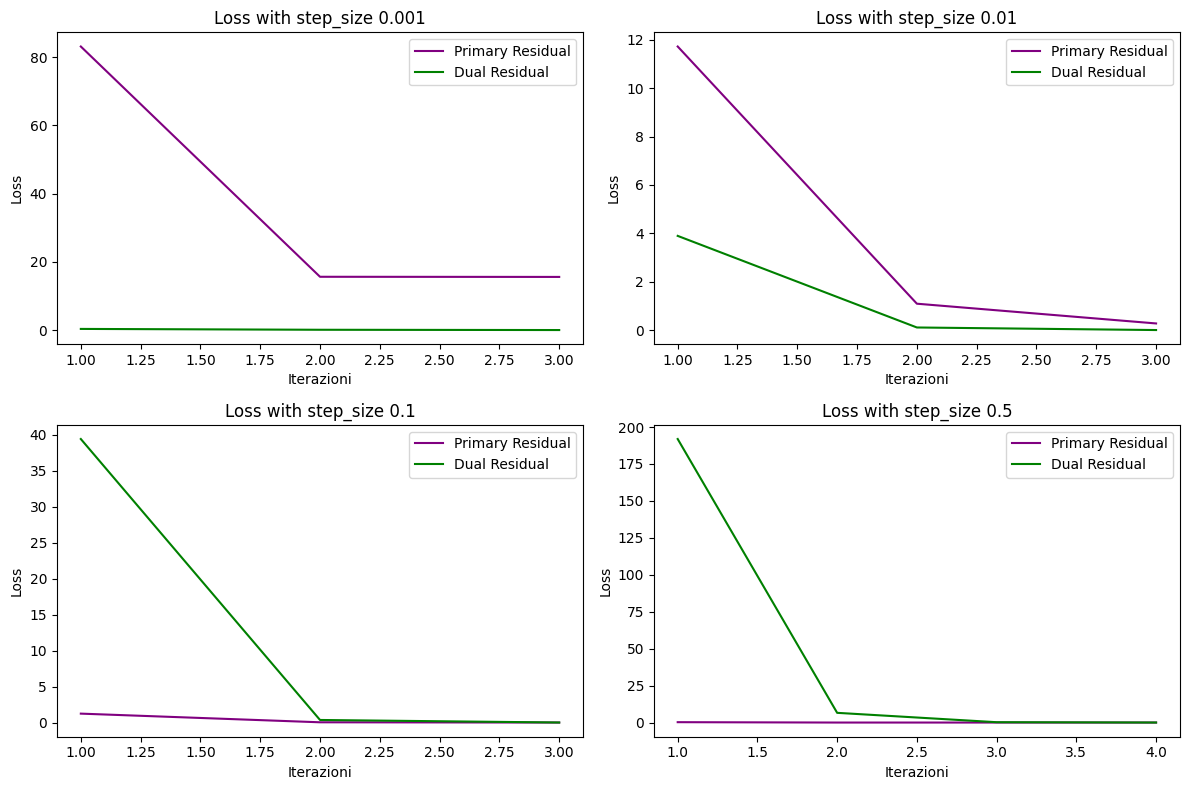

In [67]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0009953975677490234
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.8869038856339428
Distributed ADMM time with l1_penalty 0.1: 0.0010058879852294922
Distributed ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.8869038101164992
Distributed ADMM time with l1_penalty 1: 0.0019996166229248047
Distributed ADMM iterations with l1_penalty 1: 3
R^2 with l1_penalty 1: 0.8869022290331082
Distributed ADMM time with l1_penalty 10: 0.0020308494567871094
Distributed ADMM iterations with l1_penalty 10: 3
R^2 with l1_penalty 10: 0.8868859196589103


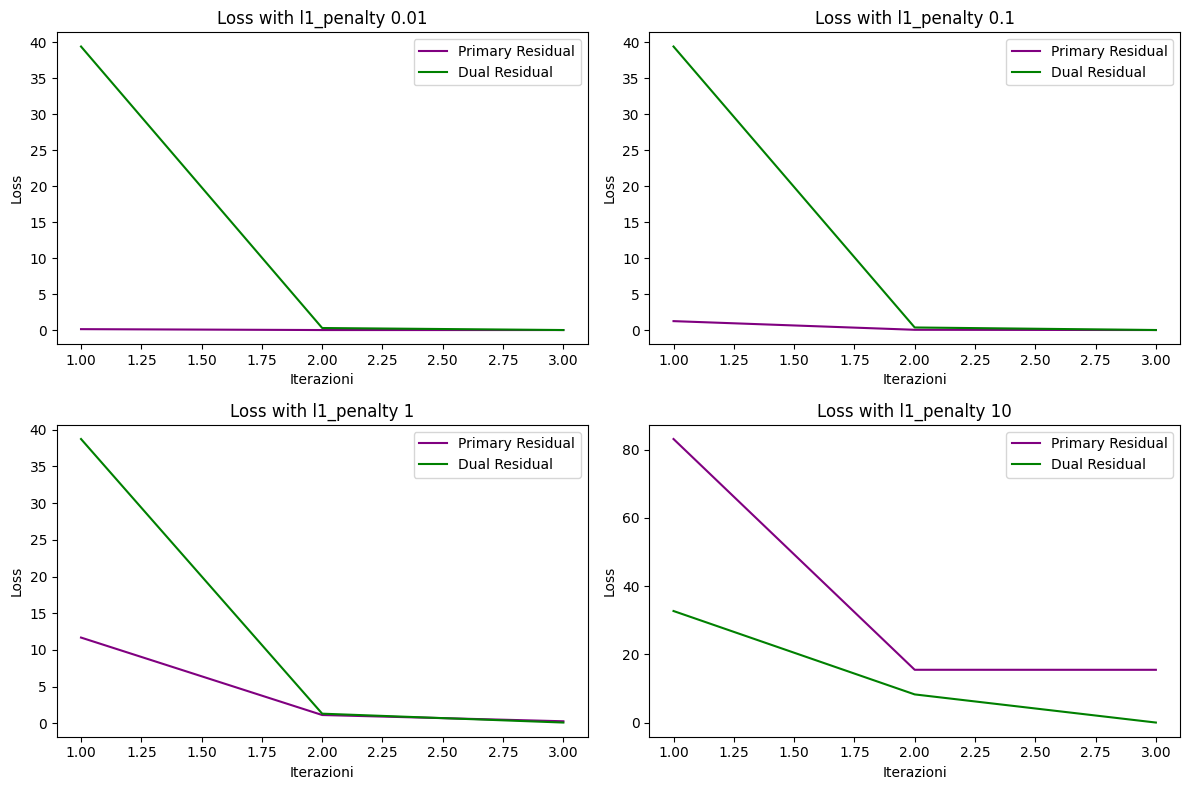

In [68]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()
plt.show()

Validation of num_agents parameter

Distributed ADMM time with 3 agents: 0.0020003318786621094
Distributed ADMM iterations with 3 agents: 3
R^2 with 3 agents: 0.8869038101164992
Distributed ADMM time with 5 agents: 0.002996683120727539
Distributed ADMM iterations with 5 agents: 3
R^2 with 5 agents: 0.8866541535802127
Distributed ADMM time with 10 agents: 0.003010272979736328
Distributed ADMM iterations with 10 agents: 4
R^2 with 10 agents: 0.8869499123471515
Distributed ADMM time with 20 agents: 0.012002229690551758
Distributed ADMM iterations with 20 agents: 12
R^2 with 20 agents: 0.8874399726056879


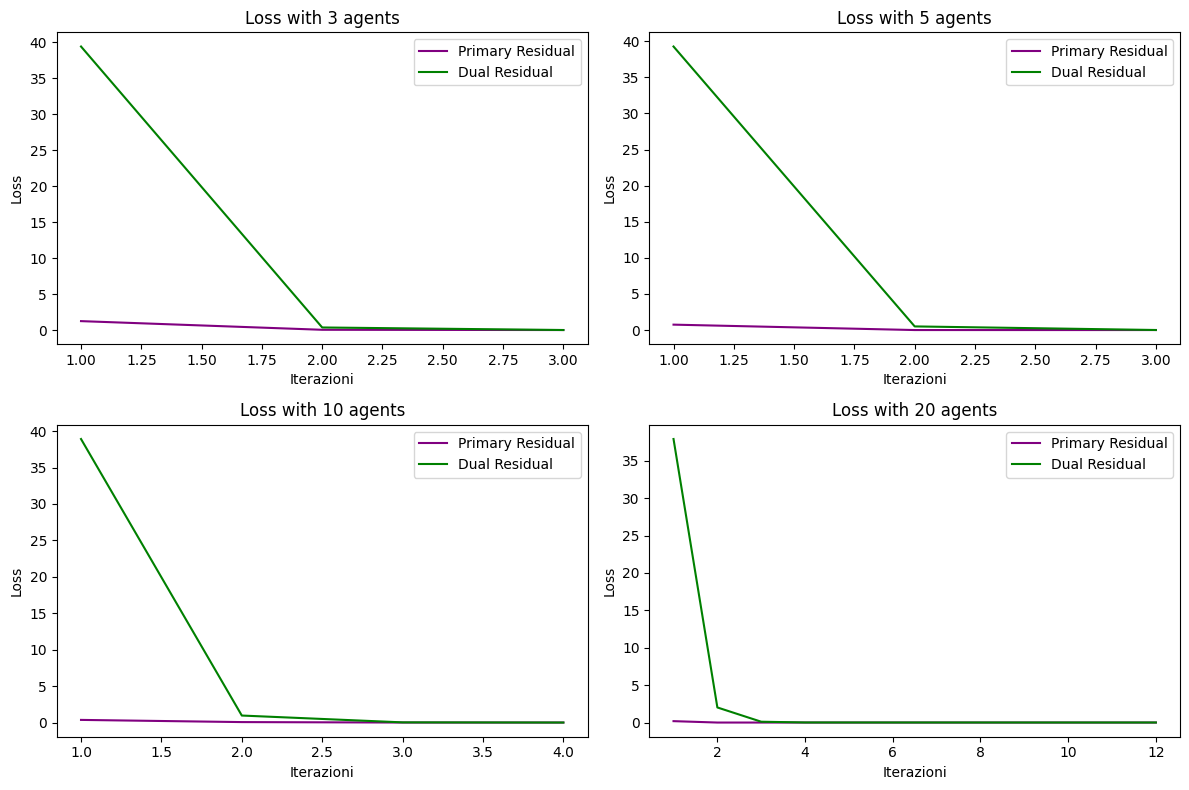

In [70]:
step_size = 0.1
l1_penalty = 0.1
agents = [3, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()
plt.show()